#UNI Machine Learning Course
#Lab 05:  Arboles de decision y k-NN



## 1.- Arboles de decision
Es uno de los enfoques de modelado predictivo utilizados en estadísticas, minería de datos y aprendizaje automático.  Esta tecnica utiliza un árbol de decisión para pasar de observaciones sobre un elemento a conclusiones sobre el valor objetivo del elemento. Los modelos de árbol en los que la variable de destino puede tomar un conjunto discreto de valores se denominan árboles de clasificación; en estas estructuras de árbol, las hojas representan etiquetas de clase y las ramas representan conjunciones de características que conducen a esas etiquetas de clase. Los árboles de decisión donde la variable objetivo puede tomar valores continuos se denominan árboles de regresión. En el análisis de decisiones, se puede usar un árbol de decisiones para representar visual y explícitamente las decisiones y la toma de decisiones.

## Criterios de division
Los algoritmos para construir árboles de decisión generalmente funcionan de arriba hacia abajo, al elegir una variable en cada paso que divida mejor el conjunto de elementos. Diferentes algoritmos utilizan diferentes métricas para medir "mejor". Estos generalmente miden la homogeneidad de la variable objetivo dentro de los subconjuntos.  Estas métricas se aplican a cada subconjunto candidato y los valores resultantes se combinan  para proporcionar una medida de la calidad de la división.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


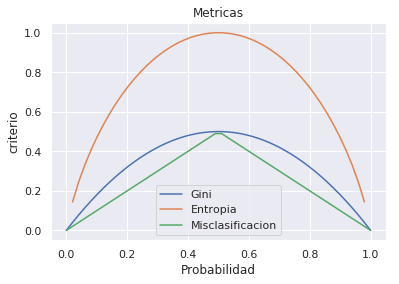

In [0]:
plt.figure(figsize=(6, 4))
proba = np.linspace(0,1,50)
plt.plot(proba, [2 * x * (1-x) for x in proba], label='Gini')
plt.plot(proba, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in proba], label='Entropia')
plt.plot(proba, [1 - max(x, 1-x) for x in proba], label='Misclasificacion')
plt.xlabel('Probabilidad')
plt.ylabel('criterio')
plt.title('Metricas')
plt.legend();

Consideremos ajustar un árbol de decisión a algunos datos generados.

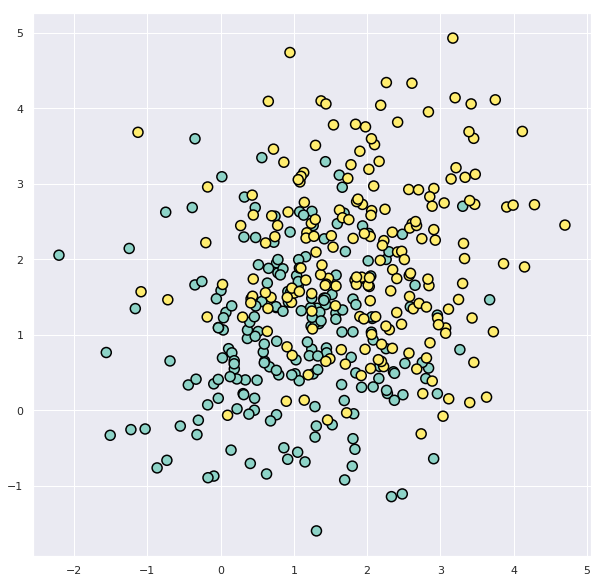

In [0]:
#Generamos muestras de dos clases ambas distribuciones normales pero con diferentes parametros

# clase 0
np.random.seed(2019)
train_data = np.random.normal(size=(200, 2),loc= 1,scale=1)
train_labels = np.zeros(200)

# clase 1
train_data = np.r_[train_data, np.random.normal(size=(200, 2), loc=2,scale=1)]
train_labels = np.r_[train_labels, np.ones(200)]


# Ploteo
plt.figure(figsize=(10,10))
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, cmap='Set3', edgecolors='black', linewidth=1.5);



Los parámetros mas importantes de [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) son:

1.   **criterion:** La función para medir la calidad de una división, "gini"  y "entropía" .  
2.   **max_depth:** la profundidad máxima del árbol;
3.   **max_features:** el número máximo de features con las que buscar la mejor partición;
4.   **min_samples_leaf:** el número mínimo de muestras en una hoja.

**Importante:** estos parámetros configurarse en función de los datos de entrada mediante cross-validation.






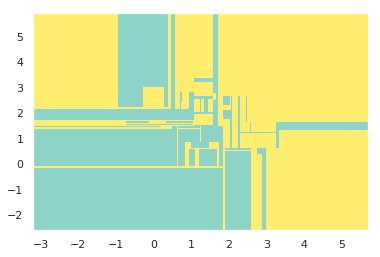

In [0]:
from sklearn.tree import DecisionTreeClassifier

# generando una grid para el DT.
def get_grid(space):
    x_min, x_max = space[:, 0].min() - 1, space[:, 0].max() + 1
    y_min, y_max = space[:, 1].min() - 1, space[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=20)

# training
tree_clf.fit(train_data, train_labels)

# plot la superficie de separacion del DT
x_grid, y_grid = get_grid(train_data)
predicted = tree_clf.predict(np.c_[x_grid.ravel(), y_grid.ravel()]).reshape(x_grid.shape)
plt.pcolormesh(x_grid, y_grid, predicted, cmap='Set3')


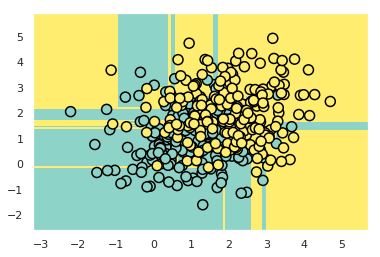

In [0]:
plt.pcolormesh(x_grid, y_grid, predicted, cmap='Set3')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, cmap='Set3', edgecolors='black', linewidth=1.5);

## Graficando el DT: ¿Cómo se ve el árbol?

 Vemos que el árbol "corta" el espacio en rectángulos. Dentro de cada rectángulo, el árbol hará la predicción de acuerdo con la etiqueta de la mayoría de los objetos en el rectangulo.

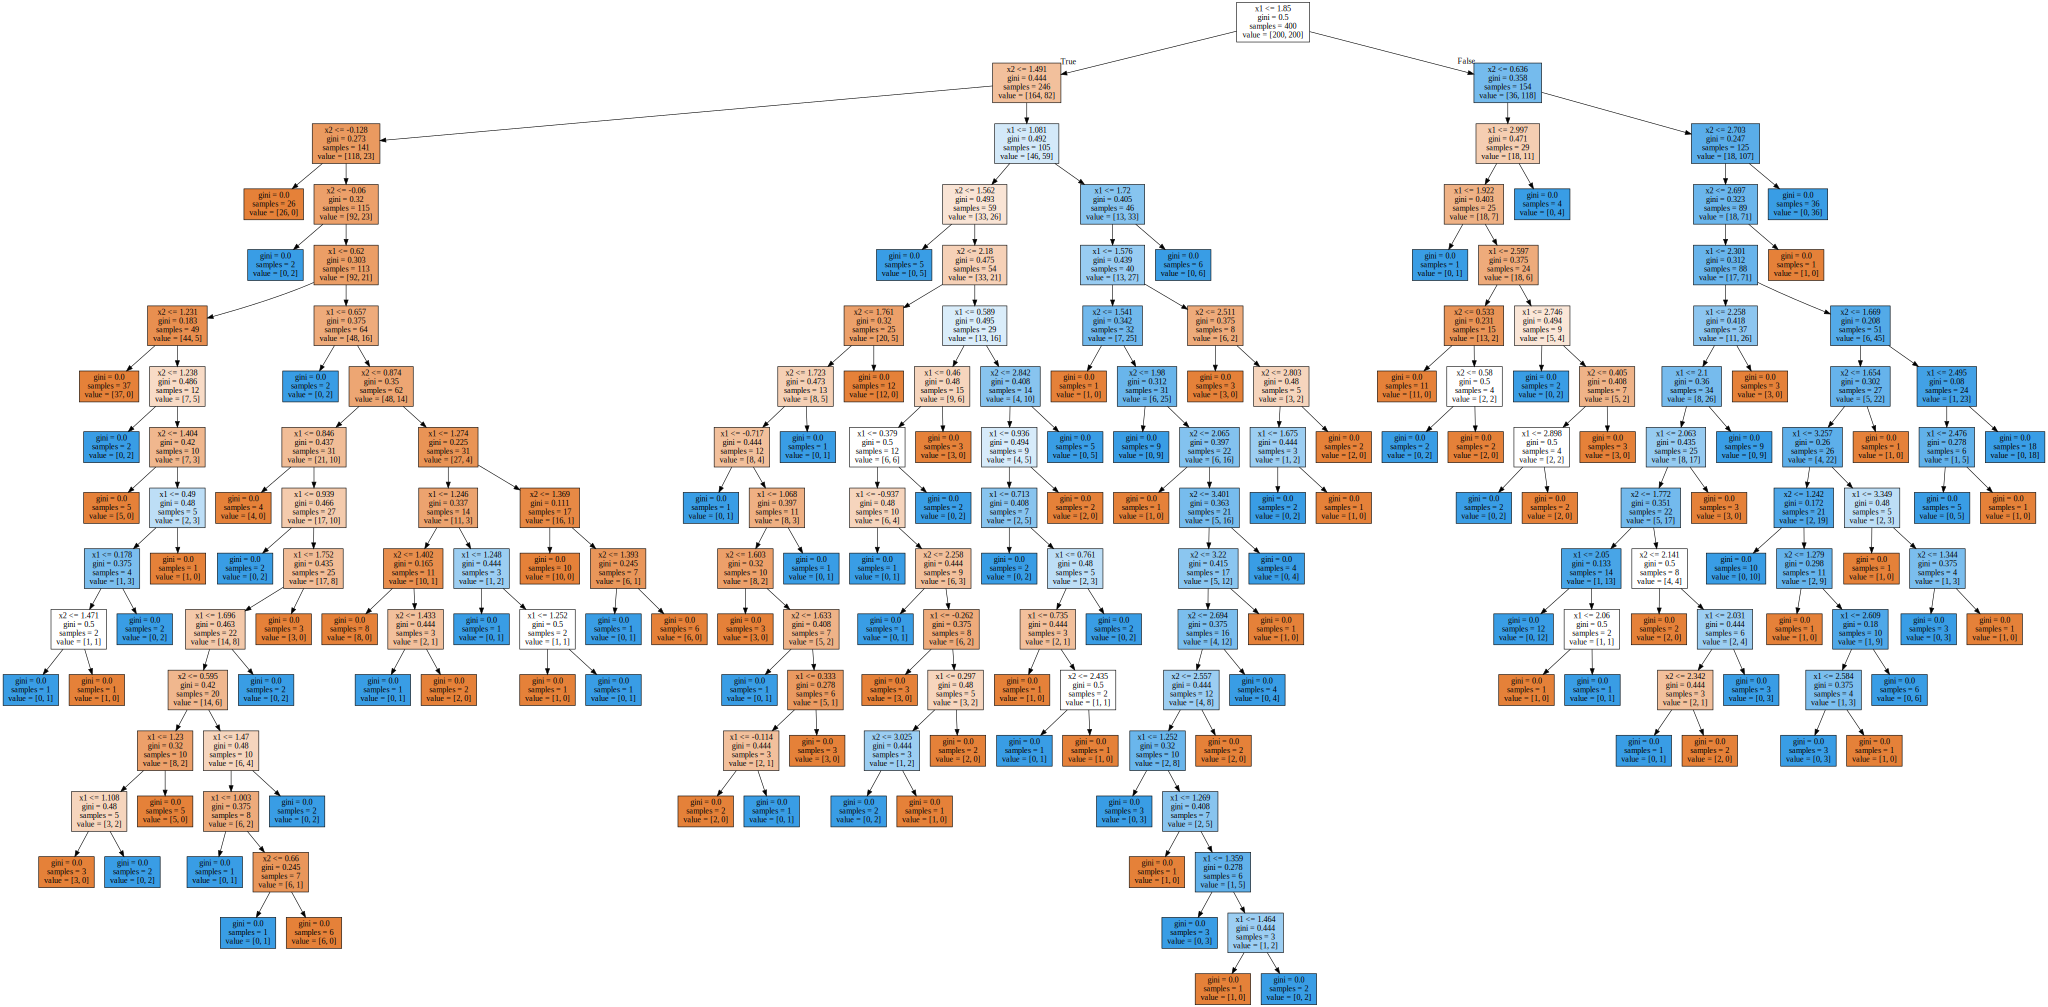

In [0]:
from sklearn import tree
from graphviz import Source
from IPython.display import SVG

tree_graph = tree.export_graphviz(tree_clf, out_file=None, feature_names=['x1', 'x2'], filled = True)
graph = Source(tree_graph)

display(SVG(graph.pipe(format='svg')))

#guardar grafica a png
# graph = pydotplus.graph_from_dot_data(tree_graph)  
# graph.write_png('arbol.png')


##Prunning

In [0]:
from sklearn.tree._tree import TREE_LEAF

def prune_tree(inner_tree, index_root, umbral):
    if inner_tree.value[index_root].min() < umbral:
        # convertir el nodo en una hoja desenlazando a sus hijos
        inner_tree.children_left[index_root] = TREE_LEAF
        inner_tree.children_right[index_root] = TREE_LEAF
        # si hay hijo visitalos
    if inner_tree.children_left[index_root] != TREE_LEAF:
        prune_tree(inner_tree, inner_tree.children_left[index_root], umbral)
        prune_tree(inner_tree, inner_tree.children_right[index_root], umbral)

prune_tree(tree_clf.tree_, 0, 20)


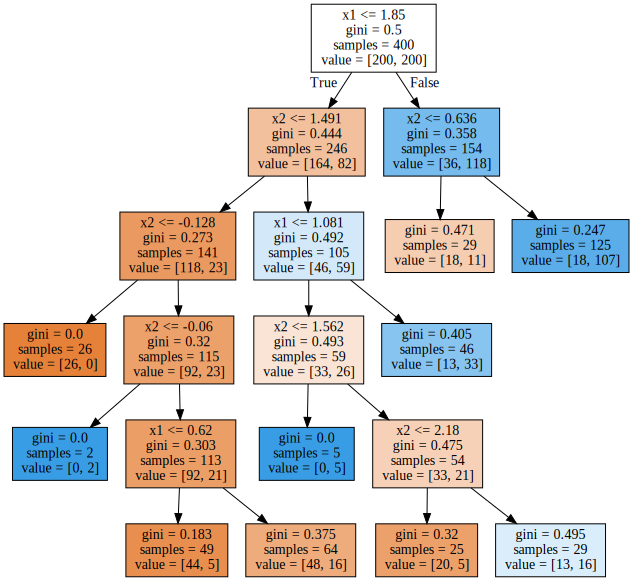

In [0]:
tree_graph = tree.export_graphviz(tree_clf, out_file=None, feature_names=['x1', 'x2'], filled = True)
graph = Source(tree_graph)

display(SVG(graph.pipe(format='svg')))

## Arbol de decisión con mas características numéricas y categoricas

In [0]:
data = pd.DataFrame({'Edad':     [17, 64, 18, 20, 38, 49, 55, 25, 29,  31, 33, 52, 65, 27, 39,  54, 30, 28, 27, 18, 47],
                     'Sexo':     ['H', 'M', 'M', 'M', 'M', 'H', 'H', 'M', 'H', 'H', 'H', 'M', 'M', 'M', 'M',  'H', 'H', 'H', 'M', 'H', 'M'],
                      'Salario': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102, 88, 35, 70, 51, 38,  94, 50, 35, 74, 32, 45], 
                      'Pagador': [1,   0,  1,  0,  1,  0,  0,  1,  1,   0,  1,  0,  0,  1,  1,   0,  1,  0,  0,  1,  0]})
data

,Edad,Sexo,Salario,Pagador
0,17,H,25,1
1,64,M,80,0
2,18,M,22,1
3,20,M,36,0
4,38,M,37,1
5,49,H,59,0
6,55,H,74,0
7,25,M,70,1
8,29,H,33,1
9,31,H,102,0


In [0]:
from sklearn import preprocessing
code = preprocessing.LabelEncoder()
code.fit(["H", "M"])
data['Sexo']= code.transform(data['Sexo'])

data = data.sort_values('Edad')
data

,Edad,Sexo,Salario,Pagador
0,17,0,25,1
2,18,1,22,1
19,18,0,32,1
3,20,1,36,0
7,25,1,70,1
18,27,1,74,0
13,27,1,51,1
17,28,0,35,0
8,29,0,33,1
16,30,0,50,1


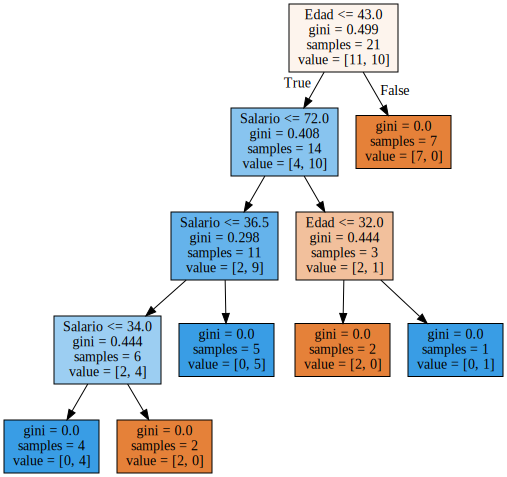

In [0]:
edad_sal_tree = DecisionTreeClassifier(criterion='gini',random_state=20)
edad_sal_tree.fit(data[['Edad', 'Sexo', 'Salario']].values, data['Pagador'].values);

tree_graph = tree.export_graphviz(edad_sal_tree, out_file=None, feature_names=['Edad', 'Sexo', 'Salario'], filled = True)
graph = Source(tree_graph)

display(SVG(graph.pipe(format='svg')))

## Arbol de decisión en problemas de regresión

Al predecir una variable numerica, la idea de una construccion de arbol sigue siendo el mismo, solo el criterio cambia

$\huge DT = \frac{1}{N_h} \sum\limits_{i =1}^{N_h} (y_i - \frac{1}{N_h} \sum\limits_{j=1}^{N_h} y_j)^2,$


donde $N_h$ es el número de muestras en una hoja, $y_i$ es el valor de la funicon objetivo. 

Al minimizar la variación alrededor de la media, se busca características que dividan el seto de entrenamiento de tal manera que los valores de la característica en cada hoja sean aproximadamente iguales.



Generemos datos distribuidos por una función con ruido.

$\huge f(x) = 4 e^{cos(-x ^ 2)} + 6 sin^2( 2- x)$

In [0]:
n_train = 250        
n_test = 250       
noise = 0.1

def f(x):
    x = x.ravel()
    return 4*np.exp(np.cos(-x ** 2)) + 6 * np.sin(-(x - 1) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 8-4
    X = np.sort(X).ravel()
    y = f(X) + 5*np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

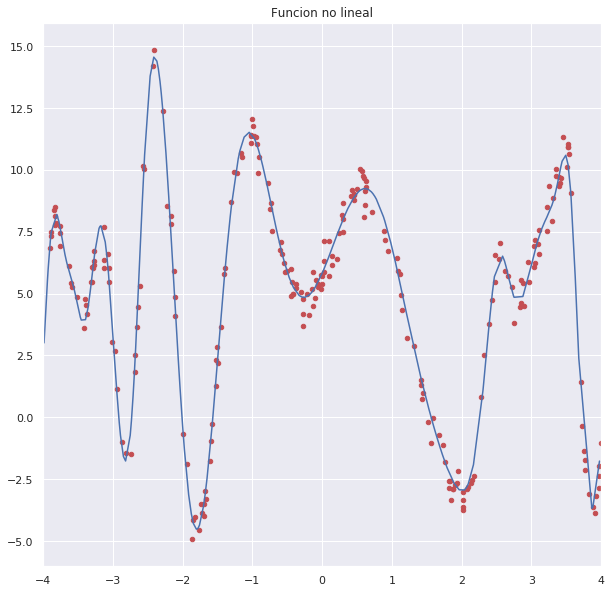

In [0]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="r", s=20)
plt.xlim([-4, 4])
plt.title("Funcion no lineal" )
plt.show()

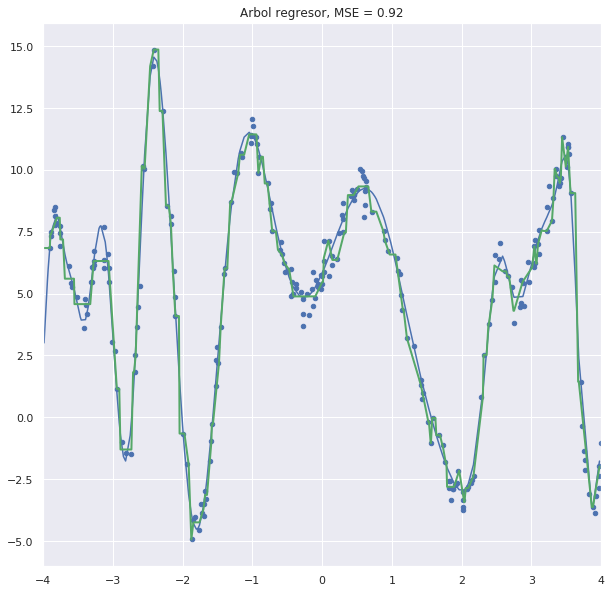

In [0]:
from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(max_depth=10, random_state=20)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize=(10, 10))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-4, 4])
plt.title("Arbol regresor, MSE = %.2f" % (np.sum((y_test - reg_tree_pred) ** 2) / n_test))
plt.show()

## 2.- Metodo del Nearest Neighbors (K-NN)

El [k-NN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) es otro método de clasificación muy popular que también se usa a veces en problemas de regresión. La intuición subyacente es que te pareces a tus vecinos. Más formalmente, el método sigue la hipótesis de la medida de similitud: si la distancia o semejanzar entre los ejemplos es corta o muy similar, entonces es muy probable que los ejemplos cercanos o similares pertenezcan a la misma clase.

**Implementaciones:**

[KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

[RadiusNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifier)

[KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor)

[RadiusNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsRegressor.html#sklearn.neighbors.RadiusNeighborsRegressor)

In [0]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets.samples_generator import make_blobs

In [0]:
X, y = make_blobs(centers=4, random_state=1, n_samples=200)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)

In [0]:
n_neighbors = 3
knn_clf = KNeighborsClassifier(weights= 'distance', n_neighbors=n_neighbors)
knn_clf.fit(X_train, y_train)
print("Predicion del set de test: {}".format(knn_clf.predict(X_test)))
print("Presicion del set de test: {:.2f}".format(knn_clf.score(X_test, y_test)))

Predicion del set de test: [2 2 1 1 0 2 0 2 2 2 2 2 0 1 1 3 1 3 1 3 0 0 2 3 1 0 2 1 0 3 1 0 2 1 0 1 3
 0 1 0 0 3 0 0 1 2 0 1 2 0]
Presicion del set de test: 0.92


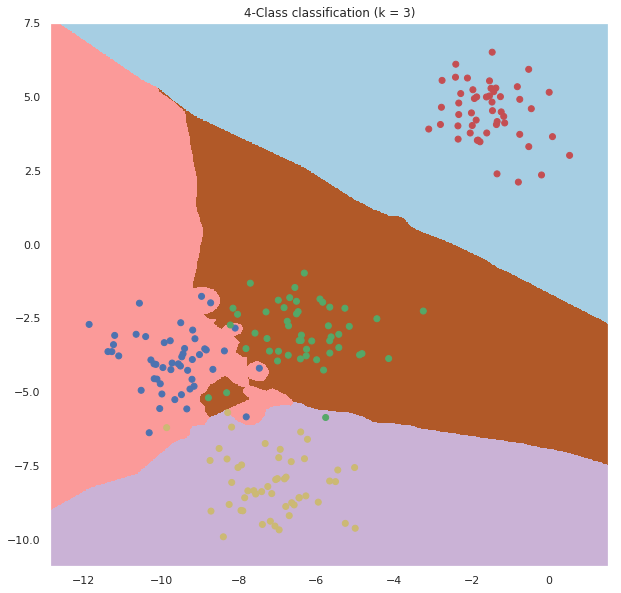

In [0]:
from matplotlib.colors import ListedColormap
cmap_1 = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF','#bdb76b'])
cmap_2 = ListedColormap(['#FF0000', '#00FF00','#00AAFF','#bdb76b'])
cmap_3 = ListedColormap(['r','b','y', 'g'])

# calcular min, max y limites
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
np.arange(y_min, y_max, 0.02))
Z = knn_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Poner el resultado en una mapa de color
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(10, 10))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Plotear los puntos de training

plt.title("4-Class classification (k = %i)" % (n_neighbors))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_3)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()


## kNN para mas de dos atributos

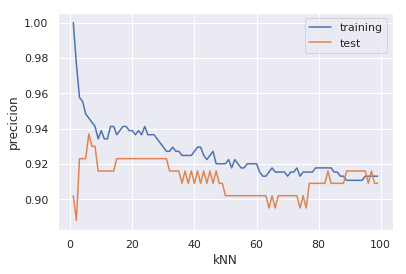

In [0]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

## print(cancer.keys())

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target,random_state=66)

# Crear sets de training y testing datasets
training_accuracy = []
test_accuracy = []
# Intentar n_neighbors from 1 to 20
neighbors_settings = range(1, 100)

for n_neighbors in neighbors_settings:
    # Crear al modelo KNN
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # Medir la precicion de training
    training_accuracy.append(clf.score(X_train, y_train))
    # Medir la precicion de generalizacion
    test_accuracy.append(clf.score(X_test, y_test))

plt.plot(neighbors_settings, training_accuracy, label="training")
plt.plot(neighbors_settings, test_accuracy, label="test")
plt.ylabel("precicion")
plt.xlabel("kNN")
plt.legend()


## Metodo de Ensemble: Iris dataset

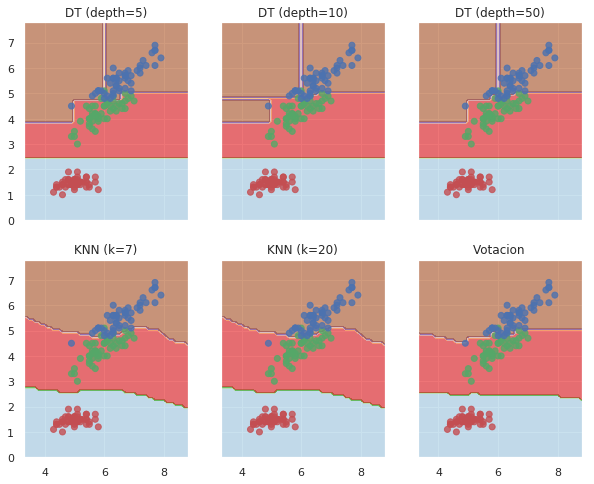

In [0]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier

iris = datasets.load_iris()
X = iris.data[:, [0,2]]
y = iris.target



# Training
clf1 = DecisionTreeClassifier(max_depth=5)
clf2 = DecisionTreeClassifier(max_depth=10)
clf3 = DecisionTreeClassifier(max_depth=50)
clf4 = KNeighborsClassifier(n_neighbors=7)
clf5 = KNeighborsClassifier(n_neighbors=20)

eclf = VotingClassifier(estimators=[('dt1', clf1), ('dt2', clf2), ('dt', clf3), ('knn1', clf4) , ('knn2', clf5)], voting='soft', weights=[2,2,3,1,10])

clf1 = clf1.fit(X,y)
clf2 = clf2.fit(X,y)
clf3 = clf3.fit(X,y)
clf4 = clf4.fit(X,y)
clf5 = clf4.fit(X,y)
eclf = eclf.fit(X,y)

cc=['r','g','b', 'y']
ycc= [cc[i]  if i<5  else '' for i in y]

# Plotting decisiones de contorno
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip([(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)],
                        [clf1, clf2, clf3, clf4, clf5, eclf],
                        ['DT (depth=5)','DT (depth=10)', 'DT (depth=50)', 'KNN (k=7)','KNN (k=20)', 'Votacion']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.6)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=ycc, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

In [0]:
from sklearn.model_selection import cross_val_score
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['DT (depth=5)','DT (depth=10)', 'DT (depth=50)', 'KNN (k=7)','KNN (k=20)', 'Votacion']):
  scores = cross_val_score(clf, X, y, cv=3,scoring='accuracy')
  print("Presicion: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
  


Presicion: 0.95 (+/- 0.02) [DT (depth=5)]
Presicion: 0.94 (+/- 0.03) [DT (depth=10)]
Presicion: 0.91 (+/- 0.04) [DT (depth=50)]
Presicion: 0.94 (+/- 0.03) [KNN (k=7)]
Presicion: 0.94 (+/- 0.03) [KNN (k=20)]
Presicion: 0.94 (+/- 0.03) [Votacion]


## Evaluacion de algoritmos de Machine Learning

Una forma evaluar el rendimiento de un algoritmo ML es hacer predicciones de datos nuevos para los que ya se conoce las respuestas. Otra forma es usar técnicas estadísticas llamadas métodos de remuestreo que permitan hacer estimaciones del rendimiento del algoritmo usado en datos nuevos.

En clase hemos visto 4 técnicas diferentes para dividir nuestro set de datos de training y crear estimaciones de rendimiento para nuestros algoritmos de ML

1.  Set de train y test (80/20) (Ampliamente usado en clase)
2.  Leave One Out Cross Validation
3.  Cross Validation  
4.   Random splits of Test and Train


**Dataset: Pima Indians Diabetes**

The dataset includes data from 768 women with 8 characteristics, in particular:

Pregnant: Number of times pregnant

Pressure: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

Plasma: Diastolic blood pressure (mm Hg)

Skin: Triceps skin fold thickness (mm)

Insulin: 2-Hour serum insulin (mu U/ml)

Mass: Body mass index (weight in kg/(height in m)^2)

Pedigree: Diabetes pedigree function

Age: (years)

La última columna del set de datos indica si la persona ha sido diagnosticada con diabetes (1) o no (0)

In [0]:
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


url = 'https://raw.githubusercontent.com/PCL-AI/MT616_2019_1/master/Lab05/pima-indians-diabetes.data.csv'

col = ['Pregnant', 'Plasma', 'Pressure', 'Skin', 'Insulin', 'Mass', 'Pedigree', 'Age', 'Class']
df = pandas.read_csv(url, names=col)
diabetes = df.values
X = diabetes[:,0:8]
Y = diabetes[:,8]

##1.  Set de train y test (80/20)

In [0]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=7)
model = LogisticRegression(C=0.1, penalty='l1')
model.fit(X_train, Y_train)
result = model.score(X_test, Y_test)
print("Precision: %.2f%%" % (result*100.0))

Precision: 75.32%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


##2. Leave One Out Cross Validation

In [0]:
loocv = model_selection.LeaveOneOut()
model = LogisticRegression(C=1, penalty='l1')
results = model_selection.cross_val_score(model, X, Y, cv=loocv)
print("Precision: %.2f%% (%.2f%%)" % (results.mean()*100.0, results.std()*100.0))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Precision: 77.73% (41.60%)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

## 3. Cross Validation

In [0]:
kfold = model_selection.KFold(n_splits=10, random_state=10)
model = LogisticRegression(C=1, penalty='l1')
results = model_selection.cross_val_score(model, X, Y, cv=kfold)

print("Precision: %.2f%% (%.2f%%)" % (results.mean()*100.0, results.std()*100.0))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Precision: 77.86% (4.58%)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


##4. Random splits of Test and Train

In [0]:
kfold = model_selection.ShuffleSplit(n_splits=10, random_state=10)
model = LogisticRegression(C=0.1, penalty='l1')
results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 76.88% (5.06%)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

## Tarea
**Primer Parte**
1.  Que falto implementar en problema de **Pima Indians Diabetes**?  Modificar y correguir lo que falta.
2.  Implementar un clasificador de ensemble para clasificacion usando como minimo una regresion logistica, un K-NN, y un arbol de decision.
3. Usar algun metodo mas optimo de validacion  
4. Clasificar el resultado con un con votacion soft y determinar los pesos mas apropiados
5. Presentar tus resultados con curvas de aprendizaje, matris de confusion de cada clasificador y de la votacion total. Calcular el score F1.

**Segunda Parte**

Revisar nuevamente el problema de **Arritmias** y usar todo lo aprendido en el curso ML hasta ahora e implementar un clasificador; entrenarlo usando metodos de validacion y/o regulacion. Presentar tus resultados visualmente usando graficas.

**Hint: tratar de construir clasificadores ineficientes (weak learners) pero muchos de ellos. (e.g., 100/tipo de clasificador)**  



In [0]:
# Primera Parte
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


url = 'https://raw.githubusercontent.com/PCL-AI/MT616_2019_1/master/Lab05/pima-indians-diabetes.data.csv'

col = ['Pregnant', 'Plasma', 'Pressure', 'Skin', 'Insulin', 'Mass', 'Pedigree', 'Age', 'Class']
df = pandas.read_csv(url, names=col)
diabetes = df.values
X = diabetes[:,0:8]
Y = diabetes[:,8]